# Indicators of WorldWide Democracy - A Jupyter NoteBook Data Science Tutorial


In the following notebook I will be demonstrating to you how to gather, organize, clean, and use data found online to visualize how democratic nations around the world are.  We will first discuss how to acquire the data.  Then, we will load and organize this data into a single usable dataset.  After that, we will clean the data and make it usable for visualization and/or machine learning.  Next, we will visualize the data and see if we notice anything interesting through inspection.  Finally, we will create a neural network to test if we can use the indicators we gathered to predict how democratic a nation is.

## Gathering the data
First we load some imports that we know we will need.

In [1]:
import numpy as np
import pandas as pd
from google.colab import drive #I used google colab for this project  
drive.mount('/content/gdrive') #That's why these two lines are here.

import pandas as pd
import numpy as np
import math
from collections import defaultdict


Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


Now, let's discuss the sources.  For most of my data, I used tables available from the world bank.  You can find that data here:  https://databank.worldbank.org/home.aspx

They allow you to make custom tables, which I did.  I made tables of the last 25 years, for every country around the world, of:  Poverty rate at $1.90 a day as a percentage, GDP per capita in USD, Life expectancy in years.

Unfortunately the world bank didn't have the best data when it comes to classifying how democratic a country is.  For that, I found data at https://www.v-dem.net/en/data/data-version-9/  

This data is absolutely fantastic.  It goes very far back, and they have multiple metrics by which they measure democracy.  The metric I used is "Electoral Democracy Index", which is a compound measurement based on many factors, such as free elections, lack of election fraud and irregularities, presence of multiple parties, freedom of speech and media, and more.

The Democracy Index data is very large, so I loaded it and then immediately trimmed it down to have only the data that I need.

In [2]:
demindex = pd.read_csv("/content/gdrive/My Drive/demindex.csv")

#keep country_name, year, v2x_polyarchy
demindex = demindex[['year','country_name','v2x_polyarchy']]
print(demindex.head())

#only keep years > 1994
demindex = demindex.loc[demindex['year'] > 1994]

print(demindex.head())

#I've examined my data and recognized that 3 of my 4 data files use years as rows and countries as columns, so I need to reorganize this data so
#that country will be a "key" (column) and data will be rows.
#to do this I will use a defaultdict where each country is a key, and the data it stores is a list of the past 25 years of demindex data.
didata = defaultdict(list)
for indx in range(len(demindex)):
  didata[demindex['country_name'].iloc[indx]].append(demindex['v2x_polyarchy'].iloc[indx])





   year country_name  v2x_polyarchy
0  1789  Afghanistan            NaN
1  1790  Afghanistan            NaN
2  1791  Afghanistan            NaN
3  1792  Afghanistan            NaN
4  1793  Afghanistan            NaN
     year country_name  v2x_polyarchy
206  1995  Afghanistan          0.094
207  1996  Afghanistan          0.085
208  1997  Afghanistan          0.077
209  1998  Afghanistan          0.077
210  1999  Afghanistan          0.077


In [0]:
#Now lets take a look at how much data is nan.  In particular we need to have non-nan democratic index data for every year, so for this analysis we will drop
#countries that are missing that data.  Since we've placed our data into a defaultdict of lists, we can use any() to check for nans.
#we should not alter the keys of a defaultdict while iterating them, so I will place the keys to remove in a list and remove them all afterwards
removals = []
for k in didata:
  res = any([math.isnan(x) for x in didata[k]])
  if res:
    removals.append(k)
for k in removals:
  del didata[k]


At this point I load and process the data of our three indicators:  poverty, life expectancy, and GDP per capita.

In [0]:
poverty = pd.read_csv("/content/gdrive/My Drive/poverty.csv")
lifeexp = pd.read_csv("/content/gdrive/My Drive/lifeexp.csv")
gdp = pd.read_csv("/content/gdrive/My Drive/gdp.csv")
ledata = defaultdict(list)
gdpdata = defaultdict(list)
povdata = defaultdict(list)
removals = set()
for k in gdp:
  if k == 'Time' or k == 'Series Name' or k == 'Series Code' or k == 'Time Code':
    continue

  #I have noticed that in the following datasets, countries are labeled as "Country [abb]" or "Country[abb]", where abb is the country's abbreviation
  #So that the data between all of our filed match, I need to remove "[abb]" from each country label
  #During this process I can also check that the given country is actually present in each dataset, because if it is not, then I cannot use it because too much information will be missing.
  #these data files also go up to 2019, but are just missing the 2019 data.   So, we need to remove the last index from each list we create so that they only go to 2018.
  for indx in range(len(k)):
    char = k[indx]
    if char == '[':
      country = k[:indx]
      if country[-1] == ' ':
        country = country[:-1]
      if country[-1] == ' ':
        country = country[:-1]
      if country in didata and k in gdp and k in lifeexp and k in poverty:
        gdpdata[country] = list(gdp[k][:24])
        ledata[country] = list(lifeexp[k][:24])
        povdata[country] = list(poverty[k][:24])
      break

# Load the data into a single dataframe

We now have 4 defaultdicts that take the same form of key=country, value = list of data entries by year.

But I still don't think this is the most useful format for actually working with the data.

I believe a good organization would be to have a single dataframe where row is year, and column keys correspond to country_code + indicator_type.

Let's remedy that.

In [5]:
#First, we can make a list of our 25 years:
years = []
for y in range(1995,2019):
  years.append(y)
#now we can put that into a new dataframe
demdf = pd.DataFrame(years)
#now lets go through the dictionaries we have made and add the data with the appropriate keys.
for country in didata:
  if country not in gdpdata or country not in povdata or country not in ledata:
      continue
  key1 = country+"_di_"
  key2 = country+"_gdp"
  key3 = country+"_pov"
  key4 = country+"_le_"
  l1 = list(didata[country])
  l2 = list(gdpdata[country])
  l3 = list(povdata[country])
  l4 = list(ledata[country])
  if len(l1) < 24 or len(l2) < 24 or len(l3) < 24 or len(l4) < 24:
    continue
  demdf[key1] = l1
  #we already know that the following countries have all 24 years because that is in the specifications for these datasets
  demdf[key2] = l2
  demdf[key3] = l3
  demdf[key4] = l4

print(demdf.head())

      0  Afghanistan_di_  ... Zimbabwe_pov Zimbabwe_le_
0  1995            0.094  ...           ..       52.044
1  1996            0.085  ...           ..        50.48
2  1997            0.077  ...           ..       49.009
3  1998            0.077  ...           ..       47.661
4  1999            0.077  ...           ..       46.466

[5 rows x 557 columns]


# Let's clean up the data in the dataframe.

I've examined the data and have seen that the world bank dataset sometimes uses empty cells for missing data, but also sometimes uses ".." for missing data

I will use pandas replace method to replace it with nan

I also have seen entries of 0, which doesn't make any sense for any of my data, so it should also be replaced with nan.

In [6]:

demdf = demdf.replace('..',np.NaN)
demdf = demdf.replace('0',np.NaN)
demdf = demdf.replace(0.0,np.NaN)

#Now let's check how much of our data is actually nan
print(demdf.shape)
#for k in demdf:
  #print(k,demdf[k].isnull().sum())





(24, 557)


I have suppressed the previous output because it is long, but what we have seen is that very little data is missing *except* for the poverty data, which has many nan entries

I've decided that we need to have at least 4 non-nan entries for any key.  So any country with >19 nan entries in poverty data will have to be removed.  Note that only

the poverty data is really missing many keys, so that may sound like a lot of missing data, but it isn't really that much.

In [7]:
removals = set()
for k in demdf:
  nancount = demdf[k].isnull().sum()
  if nancount > 21:
    for indx in range(len(k)):
      char = k[indx]
      if char == '_':
        country = k[:indx]
        removals.add(country)

for c in removals:
  del demdf[c+"_di_"]
  del demdf[c+"_gdp"]
  del demdf[c+"_pov"]
  del demdf[c+"_le_"]

print(demdf.shape)  

del demdf[0]

(24, 389)


In [8]:
#Now, I've already taken a glance at the data, and I noticed that the poverty data doesn't actually include 2018, it just leaves that row empty.
#So we are going to fill in each 2018 poverty data entry with the last poverty statistic for that given country
for k in demdf:
  if k[-4:] == '_pov':
    for i in range(22,0,-1):
      if demdf[k].iloc[i] != '..' and float(demdf[k].iloc[i]) > 0:
        demdf[k].iloc[23] = demdf[k].iloc[i]
        break

/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:205: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


Now the question is, what do we do about any other missing data?
Well first, let's examine where the missing data still is.

In [0]:
#for k in demdf:
  #if demdf[k].isnull().sum() > 0:
    #print(k,demdf[k].isnull().sum())  #<---this output is long, so I have suppressed it for now.



looking at these countries, they are mostly very stable over the last 25 years.

And even the countries that aren't *quite* as stable tend to not be missing as much data

In order to visualize our data properly, we will need to fill in our missing data somehow.

Let's use pandas ffill method, which tries to use the previous values in a column to fill in later ones.

In [9]:

print(demdf['China_pov'])
print("")
demdf = demdf.fillna(method='ffill')
print(demdf['China_pov'])
print("")
#As we can see, it can't fill in nan values that didn't have a preceding numeric value.  So now we need to backfill the values that are left.
demdf = demdf.fillna(method='backfill')
print(demdf['China_pov'])
#fantastic.

0      NaN
1      NaN
2     12.9
3      NaN
4      NaN
5     13.1
6      NaN
7      NaN
8     10.1
9      NaN
10     NaN
11     4.8
12     NaN
13     NaN
14     3.9
15     NaN
16     2.7
17     1.8
18     1.4
19     0.4
20     0.3
21     0.2
22     NaN
23     0.2
Name: China_pov, dtype: object

0      NaN
1      NaN
2     12.9
3     12.9
4     12.9
5     13.1
6     13.1
7     13.1
8     10.1
9     10.1
10    10.1
11     4.8
12     4.8
13     4.8
14     3.9
15     3.9
16     2.7
17     1.8
18     1.4
19     0.4
20     0.3
21     0.2
22     0.2
23     0.2
Name: China_pov, dtype: object

0     12.9
1     12.9
2     12.9
3     12.9
4     12.9
5     13.1
6     13.1
7     13.1
8     10.1
9     10.1
10    10.1
11     4.8
12     4.8
13     4.8
14     3.9
15     3.9
16     2.7
17     1.8
18     1.4
19     0.4
20     0.3
21     0.2
22     0.2
23     0.2
Name: China_pov, dtype: object


Now we can start exploring our data.

Let's make some visualizations of worldwide trends over the last 25 years.

To do that, let's make columns of aggregate data, by meaning the values of each country

we will do it for each indicator - democratic index, poverty rate, gdp per capita, and life expectancy

we will calculate it by putting each indicator into an array and meaning them per year

the array is of shape (#years,#countries)

In [10]:

print(demdf.shape)

di_array = np.zeros((24,97)) #388/4 
gdp_array = np.zeros((24,97))
pov_array = np.zeros((24,97))
le_array = np.zeros((24,97))

cnames = set() #we should store country names for later use

#we will need to track which index we are at for each array
di = 0
gdp = 0
pov = 0
le = 0
for k in demdf:
  suffix = k[-4:]
  prefix = k[:-4]
  if prefix not in cnames:
    cnames.add(prefix)

  if suffix == "_di_":
    di_array[:,di] = np.array(list(demdf[k]))
    di += 1
  elif suffix == "_gdp":
    gdp_array[:,gdp] = np.array(list(demdf[k]))
    gdp += 1
  elif suffix == "_pov":
    pov_array[:,pov] = np.array(list(demdf[k]))
    pov += 1
  elif suffix == "_le_":
    le_array[:,le] = np.array(list(demdf[k]))
    le += 1

#Now we can mean each array over the rows
dimeans = list(np.mean(di_array,axis=1))
gdpmeans = list(np.mean(gdp_array,axis=1))
povmeans = list(np.mean(pov_array,axis=1))
lemeans = list(np.mean(le_array,axis=1))

demdf['meandi'] = dimeans
demdf['meangdp'] = gdpmeans
demdf['meanpov'] = povmeans
demdf['meanle'] = lemeans

#and now we can add our years column
demdf['year'] = years


(24, 388)


# Now we can visualize our data
#First, let's look at life expectancy

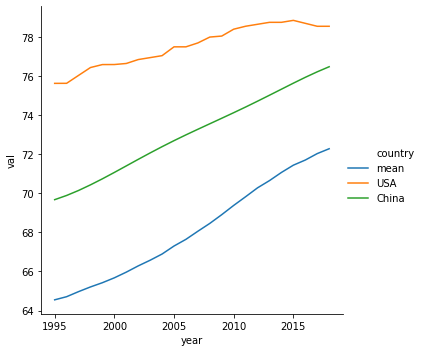

In [11]:
#Let's visualize each mean over time
import matplotlib.pyplot as plt
import seaborn as sns

#unfortunately, our data is a pretty weird format for visualization of more than one country.  Let's make a dataframe just for visualization
newdf = pd.DataFrame()
years = []
values = []
country = []
for row in range(len(demdf)):
  years.append(demdf['year'].iloc[row])
  values.append(float(demdf['meanle'].iloc[row])) 
  country.append('mean')
for row in range(len(demdf)):
  years.append(demdf['year'].iloc[row])
  values.append(float(demdf['United States_le_'].iloc[row]))
  country.append('USA')  
for row in range(len(demdf)):
  years.append(demdf['year'].iloc[row])
  values.append(float(demdf['China_le_'].iloc[row]))
  country.append('China')  


newdf['year'] = years
newdf['val'] = values
newdf['country'] = country

sns.relplot(x="year", y="val", hue="country",
             kind="line", estimator=None, data=newdf);




#Next, we look at poverty levels

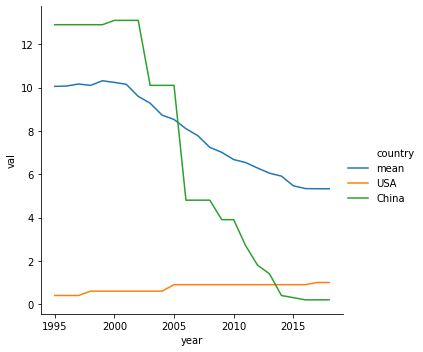

In [12]:
newdf = pd.DataFrame()
years = []
values = []
country = []
for row in range(len(demdf)):
  years.append(demdf['year'].iloc[row])
  values.append(float(demdf['meanpov'].iloc[row])) 
  country.append('mean')
for row in range(len(demdf)):
  years.append(demdf['year'].iloc[row])
  values.append(float(demdf['United States_pov'].iloc[row]))
  country.append('USA')  
for row in range(len(demdf)):
  years.append(demdf['year'].iloc[row])
  values.append(float(demdf['China_pov'].iloc[row]))
  country.append('China')  

newdf['year'] = years
newdf['val'] = values
newdf['country'] = country

sns.relplot(x="year", y="val", hue="country",
             kind="line", estimator=None, data=newdf);

#Now we can look at GDP Per capita

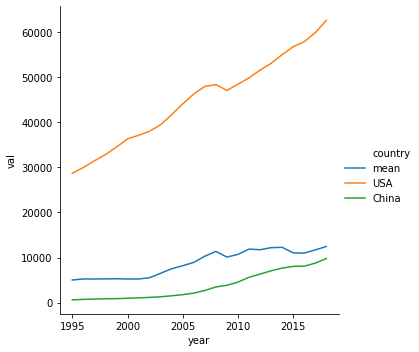

In [13]:
newdf = pd.DataFrame()
years = []
values = []
country = []
for row in range(len(demdf)):
  years.append(demdf['year'].iloc[row])
  values.append(float(demdf['meangdp'].iloc[row])) 
  country.append('mean')
for row in range(len(demdf)):
  years.append(demdf['year'].iloc[row])
  values.append(float(demdf['United States_gdp'].iloc[row]))
  country.append('USA')  
for row in range(len(demdf)):
  years.append(demdf['year'].iloc[row])
  values.append(float(demdf['China_gdp'].iloc[row]))
  country.append('China')  

newdf['year'] = years
newdf['val'] = values
newdf['country'] = country

sns.relplot(x="year", y="val", hue="country",
             kind="line", estimator=None, data=newdf);

#Finally lets look at democratic index.

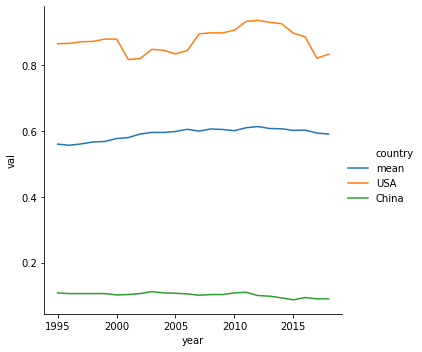

In [14]:
newdf = pd.DataFrame()
years = []
values = []
country = []
for row in range(len(demdf)):
  years.append(demdf['year'].iloc[row])
  values.append(float(demdf['meandi'].iloc[row])) 
  country.append('mean')
for row in range(len(demdf)):
  years.append(demdf['year'].iloc[row])
  values.append(float(demdf['United States_di_'].iloc[row]))
  country.append('USA')  
for row in range(len(demdf)):
  years.append(demdf['year'].iloc[row])
  values.append(float(demdf['China_di_'].iloc[row]))
  country.append('China')  

newdf['year'] = years
newdf['val'] = values
newdf['country'] = country

sns.relplot(x="year", y="val", hue="country",
             kind="line", estimator=None, data=newdf);

#The last visualization I'd like to do is to see if we can actually see a corrlation between democratic index and the chosen indicators.

to do this, we need to normalize each variable.  We will minmax feature scaling to scale each variable between 0 and 1

We can do that by using the following on each array of data:
(X-X_min)/(X_max-X_min)

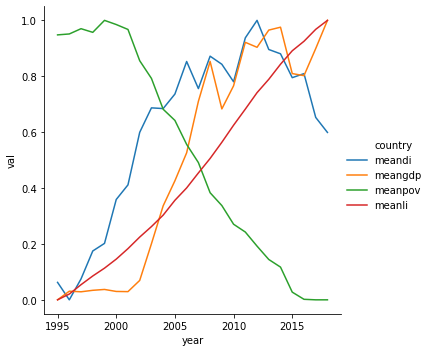

In [15]:
arr = np.array(demdf['meanle'])
arrmin = np.min(arr)
arrmax = np.max(arr)
arr = (arr-arrmin)/(arrmax-arrmin)
demdf['meanle'] = list(arr)

arr = np.array(demdf['meanpov'])
arrmin = np.min(arr)
arrmax = np.max(arr)
arr = (arr-arrmin)/(arrmax-arrmin)
demdf['meanpov'] = list(arr)

arr = np.array(demdf['meangdp'])
arrmin = np.min(arr)
arrmax = np.max(arr)
arr = (arr-arrmin)/(arrmax-arrmin)
demdf['meangdp'] = list(arr)

arr = np.array(demdf['meandi'])
arrmin = np.min(arr)
arrmax = np.max(arr)
arr = (arr-arrmin)/(arrmax-arrmin)
demdf['meandi'] = list(arr)

#and now we can do a visualization of the trend of each mean
newdf = pd.DataFrame()
years = []
values = []
country = []
for row in range(len(demdf)):
  years.append(demdf['year'].iloc[row])
  values.append(float(demdf['meandi'].iloc[row])) 
  country.append('meandi')
for row in range(len(demdf)):
  years.append(demdf['year'].iloc[row])
  values.append(float(demdf['meangdp'].iloc[row]))
  country.append('meangdp')  
for row in range(len(demdf)):
  years.append(demdf['year'].iloc[row])
  values.append(float(demdf['meanpov'].iloc[row]))
  country.append('meanpov')  
for row in range(len(demdf)):
  years.append(demdf['year'].iloc[row])
  values.append(float(demdf['meanle'].iloc[row]))
  country.append('meanli')  

newdf['year'] = years
newdf['val'] = values
newdf['country'] = country

sns.relplot(x="year", y="val", hue="country",
             kind="line", estimator=None, data=newdf);




In our last visualization, we can see some interesting trends.

We can see a pretty strong correlation between democratic index and gdp.

There also looks to be some correlation between poverty and DI

but there doesn't look to be much correlation between poverty and DI


# Let's use machine learning by making a neural network.

We can try to predict democracy index with our 3 indicators (gdp, poverty, and life expectancy)

In [0]:
#We need to create a numpy array of our data.  One row is a sample, and a sample will have [year,pov,li,gdp], and the target values are an array where row corresponds democratic index
x = np.zeros((24*97,4))
y = np.zeros((24*97,1))

#also, we want to make sure we label what the countries are for later
clabels = []

curr = 0
for row in range(len(demdf)):
  year = demdf['year'].iloc[row]
  for c in cnames:
    if c+"_pov" not in demdf:
      continue
    clabels.append(c)
    pov = demdf[c+"_pov"].iloc[row]
    di = pov = demdf[c+"_di_"].iloc[row]
    gdp = demdf[c+"_gdp"].iloc[row]
    le = demdf[c+"_le_"].iloc[row]
    y[curr,0] = float(di)
    x[curr,0] = float(year)
    x[curr,1] = float(pov)
    x[curr,2] = float(gdp)
    x[curr,3] = float(le)
    curr += 1


#We will use the keras library to create a neural network.

Our data is not too complicated, so we will use a simple feed-forward neural network that has one hidden layer.  

We will use relu as the activation for our first layer, and since our final output is a percentage, we can use sigmoid as our final activation function

Also, we will add a normalization layer to normalize our data before it enters our first layer

In [17]:
#For our neural network, we are going to use keras
from keras.models import Sequential
from keras.layers import Dense, Activation, BatchNormalization


model = Sequential()
model.add(Dense(8, input_dim=4))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dense(1))
model.add(Activation('sigmoid'))

#We use Adam as our optimizer, and mean squared error as our loss function
model.compile(optimizer='Adam',
              loss='mse')

model.summary()

Using TensorFlow backend.







Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 8)                 40        
_________________________________________________________________
batch_normalization_1 (Batch (None, 8)                 32        
_________________________________________________________________
activation_1 (Activation)    (None, 8)                 0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 9         
_________________________________________________________________
activation_2 (Activation)    (None, 1)                 0         
Total params: 81
Trainable params: 65
Non-trainable params: 16
_________________________________________________________________


Let's shuffle our data and split it into test and train data

In [0]:
from sklearn.model_selection import train_test_split
x_train,x_test,y_train,y_test = train_test_split(x,y,test_size=0.3)


Now we train the network

In [19]:
model.fit(x_train,y_train,batch_size=32,epochs=50)




Epoch 1/50





1629/1629 [==============================] - 0s 231us/step - loss: 0.0515
Epoch 2/50
1629/1629 [==============================] - 0s 41us/step - loss: 0.0422
Epoch 3/50
1629/1629 [==============================] - 0s 42us/step - loss: 0.0385
Epoch 4/50
1629/1629 [==============================] - 0s 44us/step - loss: 0.0366
Epoch 5/50
1629/1629 [==============================] - 0s 41us/step - loss: 0.0350
Epoch 6/50
1629/1629 [==============================] - 0s 40us/step - loss: 0.0348
Epoch 7/50
1629/1629 [==============================] - 0s 39us/step - loss: 0.0339
Epoch 8/50
1629/1629 [==============================] - 0s 42us/step - loss: 0.0329
Epoch 9/50
1629/1629 [==============================] - 0s 45us/step - loss: 0.0327
Epoch 10/50
1629/1629 [==============================] - 0s 53us/step - loss: 0.0323
Epoch 11/50
1629/1629 [==============================] - 0s 41us/step - loss: 0.0326
Epoch 12/50
1629/1629 [==============================] - 0s 43us/

And finally, let's test our accuracy

In [20]:
model.test_on_batch(x_test,y_test)

0.03533708

This accuracy is quite good.  The number it is returning here is MSE, which means that it generally predicts pretty closely how democratic a nation is.  It's actually interesting, our tested predictions are almost as accurate as the training accuracy.

This means that the chosen indicators are closely tied to how democratic a country is, though that is not necessarily always the case.

There is much more that could be done with this data, given more time.  In particular, overlaying this information onto a global map would be very cool, and perhaps that is something that I will be doing in the future.